# Forecasting CNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024
Updated: 03/17/2025

This script:
1. Opens the CSV files with the CFS forecasts. 
2. Runs the forecast through the trained Gaussian Process model. 
3. Produces an ensemble of RNBS forecasts for each of the Great Lakes.
4. Saves the forecast to a CSV file.
5. Creates a timeseries plot and saves it as a PNG file. 

This script needs the following files:

- input
    - GP_trained_model.joblib
    - RF_trained_model.joblib
    - LR_trained_model.joblib
    - NN_trained_model.joblib
    - x_scaler.joblib
    - y_scaler.joblib
- data
    - cfs_forecast_data.db

In [19]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import sqlite3
import os
import sys

In [35]:
from importlib import reload
import src.data_processing
reload(src.data_processing)

<module 'src.data_processing' from '/Users/ljob/Desktop/cnbs-predictor/src/data_processing.py'>

In [36]:
# Add the path to the src directory (two levels up)
sys.path.append(os.path.abspath('../../'))
from src.data_processing import filter_predictions, predict_cnbs, format_predictions, add_df_to_db
from src.calculations import convert_mm_to_cms

# User Input

In [22]:
# This is the directory where you cloned the repo
path_to_repo = '/Users/ljob/Desktop/'

# Path to download data to
dir = path_to_repo + 'cnbs-predictor/data/'

# Path to input CFS forecast database
cfs_database = dir + 'input/cfs_forecast_data.db'

# Path for output of CNBS forecast to a database
cnbs_database = dir + 'forecast/cnbs_forecast.db'

# Open scalers
x_scaler = dir + 'input/x_scaler.joblib'
y_scaler = dir + 'input/y_scaler.joblib'

# Define models to use along with their paths
models_info = [{'model': 'GP', 'path': dir + 'input/GP_trained_model.joblib'},
               {'model': 'RF', 'path': dir + 'input/RF_trained_model.joblib'},
               {'model': 'LR', 'path': dir + 'input/LR_trained_model.joblib'},
               {'model': 'NN', 'path': dir + 'input/NN_trained_model.joblib'}]

# Begin Script

In [23]:
# Create a connection to the SQLite database
conn = sqlite3.connect(cfs_database)

# Define the query to get all the data
query = '''
SELECT * FROM cfs_forecast_data
'''

# Execute the query and fetch the data into a DataFrame
data = pd.read_sql(query, conn)

# Close the connection once done
conn.close()

data.set_index(['cfs_run', 'month', 'year'], drop=False, inplace=True)

In [24]:
# This creates 1 column with a variable name that combines column names from the database
# It just makes it simplier for the moment to call the data
data['variable'] = data['lake'] + '_' + data['surface_type'] + '_' + data['cnbs']

In [ ]:
# The variable names based on the above step in the order that the need to be in based on the order of variables during training
variables = ['superior_lake_precipitation', 'erie_lake_precipitation', 'ontario_lake_precipitation', 
             'michigan-huron_lake_precipitation', 'superior_land_precipitation', 'erie_land_precipitation',
             'ontario_land_precipitation', 'michigan-huron_land_precipitation', 'superior_lake_evaporation',
             'erie_lake_evaporation', 'ontario_lake_evaporation', 'michigan-huron_lake_evaporation',
             'superior_land_evaporation', 'erie_land_evaporation', 'ontario_land_evaporation',
             'michigan-huron_land_evaporation', 'superior_lake_air_temperature', 'erie_lake_air_temperature',
             'ontario_lake_air_temperature', 'michigan-huron_lake_air_temperature', 'superior_land_air_temperature',
             'erie_land_air_temperature', 'ontario_land_air_temperature', 'michigan-huron_land_air_temperature'
             ]

# Use a loop to create the DataFrame
X = pd.DataFrame({
    var: data.loc[data['variable'] == var, 'value'] for var in variables
})


# For any reason, in a worse case scenario and there are NaNs (which there would never ever be missing data), drop the rows that include them
# Check first to see if there are NaN values in the DataFrame
if X.isna().any().any():
    # Remove rows with NaN values
    print("NANs were found in the input dataset. Removing them before continuing.")
    X = X.dropna(how='any')

In [27]:
# This removes any old cfs forecasts that we do not need cnbs forecasts for (such as forecasts for months that have passed). 
X_filtered = filter_predictions(X)

First month forecast: 3


In [60]:
# Initialize an empty dictionary to store predictions by model name
model_predictions = {}

# Process each model and add to DB
for model_info in models_info:
    model_name = model_info['model']
    df_y = predict_cnbs(X_filtered, x_scaler, y_scaler, models_info, model_name)
    if df_y is not None:
        # Store the predictions in the dictionary with the model name as the key
        model_predictions[model_name] = df_y
        
        df_y_formatted = format_predictions(df_y, model_name)
        add_df_to_db(cnbs_database, 'cnbs_forecast', df_y)

        # Calculate median values for each model for each month
        # Group by 'year', 'month', 'lake', and 'cnbs' and calculate median only on the 'value' column
        df_median = df_y_formatted.groupby(['year', 'month', 'lake', 'cnbs'])['value'].median().round(3).reset_index()
        
        # Add a new column 'model_name' with the value "GP"
        df_median['model_name'] = model_name

        # Reorder columns to place 'model_name' between 'month' and 'lake'
        df_median = df_median.sort_values(by=['month', 'year', 'model_name', 'lake', 'value']).set_index(['month', 'year'])

        add_df_to_db(cnbs_database, 'cnbs_forecast_median', df_median)
        print(f"Addedforecast values using {model_name} to database {cnbs_database}.")



Addedforecast values using GP to database /Users/ljob/Desktop/cnbs-predictor/data/forecast/cnbs_forecast.db.
Addedforecast values using RF to database /Users/ljob/Desktop/cnbs-predictor/data/forecast/cnbs_forecast.db.
Addedforecast values using LR to database /Users/ljob/Desktop/cnbs-predictor/data/forecast/cnbs_forecast.db.
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
Addedforecast values using NN to database /Users/ljob/Desktop/cnbs-predictor/data/forecast/cnbs_forecast.db.


In [29]:
# Calculate the median forecast value for each month from the entire ensemble
combined_dataset = pd.concat(model_predictions)
df_median_mm = combined_dataset.groupby(['year', 'month']).median().round(3) # Rounds to 3 decimal places

In [30]:
# Save to a CSV [mm]
df_median_mm.to_csv(f'{dir}forecast/CNBS_forecast_mm.csv', sep='\t', index=True)

# Convert mm to cms
df_cms = convert_mm_to_cms(df_median_mm).round(3)

# Save to a CSV [cms]
df_cms.to_csv(f'{dir}forecast/CNBS_forecast_cms.csv', sep='\t', index=True)

In [61]:
median_predictions = {}
for model_name, df in model_predictions.items():
    median_predictions[model_name] = df.groupby(['year', 'month']).median().round(3)

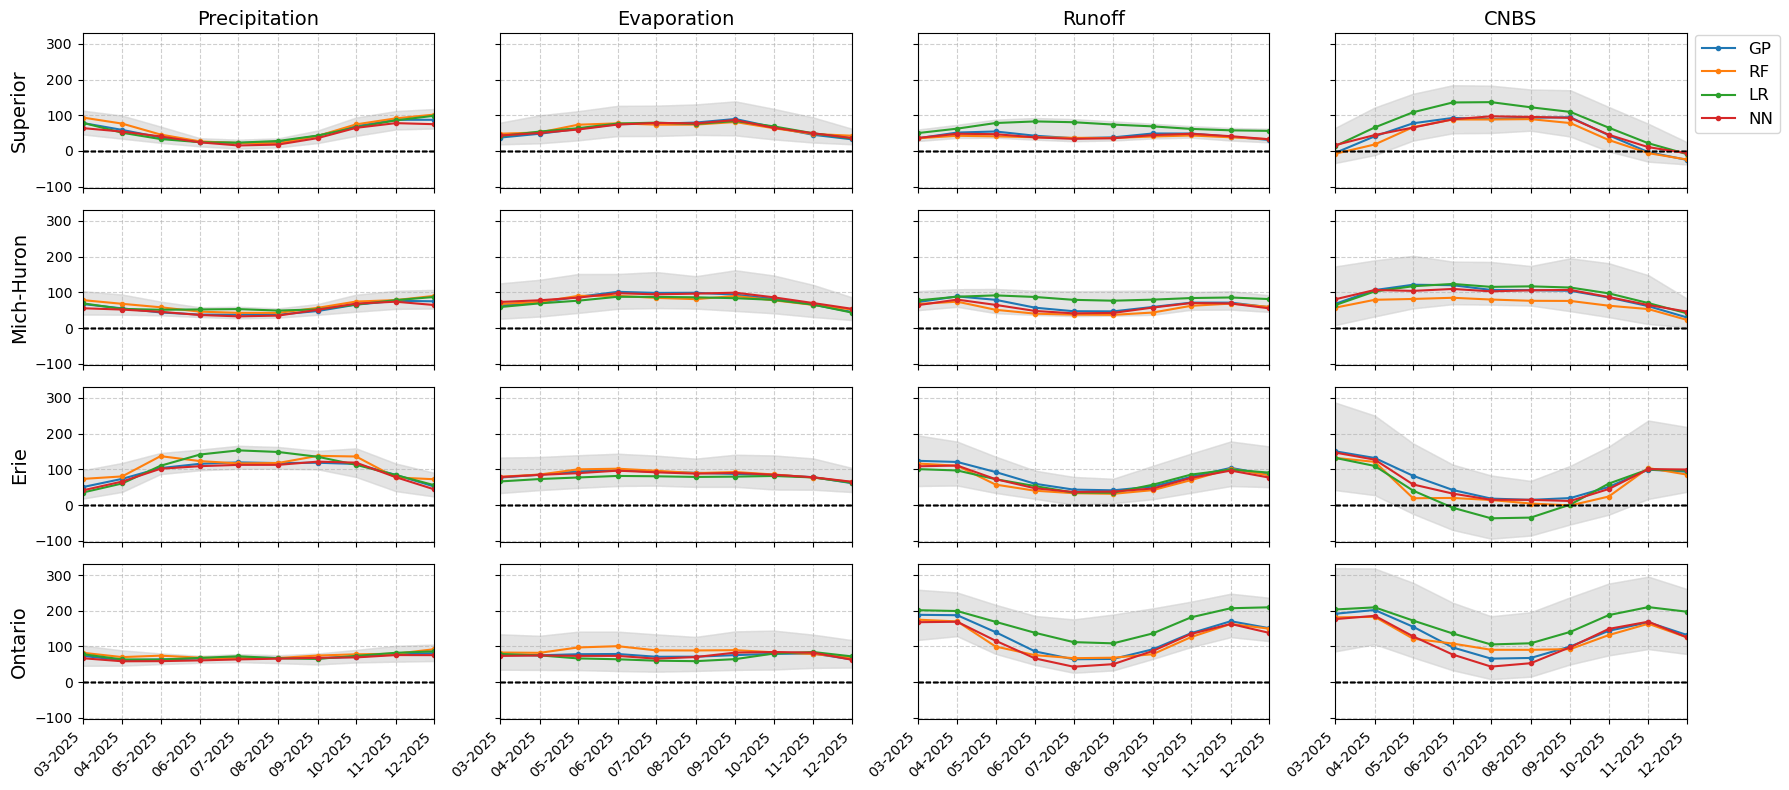

In [31]:
# Columns of interest in the order we want to plot them
columns = ['superior_evaporation', 'superior_precipitation', 'superior_runoff', 'superior_cnbs',
           'michigan-huron_evaporation', 'michigan-huron_precipitation', 'michigan-huron_runoff', 'michigan-huron_cnbs',
           'erie_evaporation', 'erie_precipitation', 'erie_runoff', 'erie_cnbs',
           'ontario_evaporation', 'ontario_precipitation', 'ontario_runoff', 'ontario_cnbs']

# Create a 1x4 subplot grid
fig, axs = plt.subplots(4, 4, figsize=(18, 8))

global_y_min, global_y_max = float('inf'), float('-inf')  # Initialize to extremes. This will update in the loop 

# Loop over the columns and plot the medians for each dataset
for i, column in enumerate(columns):
    row = i // 4  # Row index (integer division by 4)
    col = i % 4   # Column index (remainder after division by 4)

    lower_bound = combined_dataset.groupby(['year', 'month'])[column].quantile(0.025).reset_index()
    upper_bound = combined_dataset.groupby(['year', 'month'])[column].quantile(0.975).reset_index()

    for model_name, df in model_predictions.items():
        # Get the grouped DataFrame for the current model
        median_df = df.groupby(['year', 'month']).median().round(3)

        # Add a 'date' column to the median DataFrame
        median_df = median_df.reset_index()
        median_df['date'] = pd.to_datetime(median_df[['year', 'month']].assign(day=1))

        # Plot the medians for the current dataset on the same subplot
        axs[row, col].plot(median_df['date'], median_df[column], marker='o', markersize=3, label=model_name)

        # Add the shaded region (confidence band)
        axs[row, col].fill_between(median_df['date'], lower_bound[column], upper_bound[column], color='lightgray', alpha=0.2)
        axs[row, col].axhline(0, color='black', linestyle='--', linewidth=1) # Add a dashed line on 0
        axs[row, col].grid(True, linestyle='--', alpha=0.6) # Turn on a grid
        axs[row, col].set_yticks(np.arange(-1000, 1000, 100)) # Force y ticks on every 100

        # Update the global y-axis limits based on the current dataset
        # This allows us to set a y min and y max that is the same for all of the figures at the end
        current_y_min = lower_bound[column].min()
        current_y_max = upper_bound[column].max()
        global_y_min = min(global_y_min, current_y_min)
        global_y_max = max(global_y_max, current_y_max)

    # Set titles based on row and column
    if row == 0:
        axs[row, col].set_title(['Precipitation', 'Evaporation', 'Runoff', 'CNBS'][col], fontsize=14)
    else:
        axs[row, col].set_title('')

    # Format x-axis for the last row (set x-tick labels)
    if row == 3:
        axs[row, col].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%Y')) # Format the dates on the x axis
        axs[row, col].tick_params(axis='x', rotation=45)  # Rotate the x-axis labels for better readability
        for label in axs[row, col].get_xticklabels(): # Position the labels
            label.set_horizontalalignment('right')
    else:
        axs[row, col].set_xticklabels([]) # Turn off x axis labels on all of the plots but the bottom row

    # Set y-axis labels for the first column only
    if col == 0:
        axs[row, col].set_ylabel(['Superior', 'Mich-Huron', 'Erie', 'Ontario'][row], fontsize=14)
    else:
        axs[row, col].set_yticklabels([]) # Turn off titles 

# Set consistent y-axis limits across all subplots
for row in range(4):
    for col in range(4):
        axs[row, col].set_ylim(global_y_min - 10, global_y_max + 10)
        axs[row, col].set_xlim(median_df['date'].iloc[0], median_df['date'].iloc[-1])

# Position the legend outside the plot area to the right
axs[0, 3].legend(loc='lower left', bbox_to_anchor=(1, 0.3),fontsize=12)

# Save the figure as a PNG file
plt.savefig(f'{dir}forecast/CNBS_forecasts.png')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
